0
100
200
300
400
500
600
700
800
900
Arrived at final approximation to the posterior distribution
Estimating kernel desnity
Beginning plotting
Adding labels


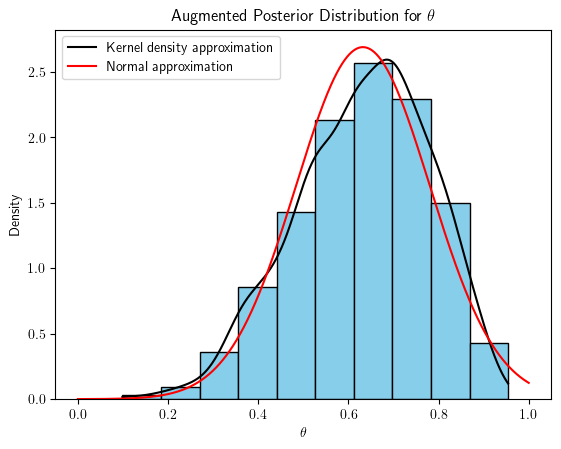

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
# import matplotlib as mpl
from scipy.stats import gaussian_kde
from scipy.stats import norm

## Data imputation algorithm

# Idea is that over iterations, you are updating your current approximation to the posterior distribution
# And over imputations, you are generating a sample from the current approximation to the posterior distribution
# So, each imputation is generated from the current approximation to the posterior distribution

## Genetic linkage example

# Observed data Y = (125, 18, 20, 34)
# For mini genetic linkage model Y = (14, 0, 1, 5)
# And the last observed data option is Y = (13, 1, 2, 3)
# Assuming uniform prior on theta

y1, y2, y3, y4 = [13, 1, 2, 3]

numIterations = 1000
numImputations = 2000
posteriorApproximations = np.zeros([numIterations, numImputations])
randomIndices = random.choices(range(numImputations), k = numIterations)
currentTheta = np.random.uniform(0, 1, numImputations)

for iiIteration in range(numIterations):

    # Display every n'th iteration

    if iiIteration % 100 == 0:
        
        print(iiIteration)

    # Generate m imputations / latent variables from the current posterior distribution (represented by a sample of thetas not just one theta)

    currentImputations = np.zeros([numImputations])

    for jjImputation in range(numImputations):

        thetaStar = currentTheta[jjImputation]
        currentImputations[jjImputation] = np.random.binomial(y1, thetaStar / (thetaStar + 2), 1)

    # Now sample theta star from Beta(v1, v2) where v1 = x2 + y4 + 1 and v2 = y2 + y3

    for jjImputation in range(numImputations):

        currentLatentVariable = currentImputations[random.randint(0, numImputations - 1)] # drawn from the conditional predictive distribution given the current approximation to the posterior
        currentTheta[jjImputation] = np.random.beta(currentLatentVariable + y4 + 1, y2 + y3 + 1, 1) # sampling the current approximation to the posterior
        # (which of course depends on the latent variables that in turn depend on the previous approximation to the posterior)
        posteriorApproximations[iiIteration, jjImputation] = currentTheta[jjImputation]

    if iiIteration == (numIterations - 1):

        print('Arrived at final approximation to the posterior distribution')


# Generate the pdfs to plot as well

posteriorSample = currentTheta
print('Estimating kernel desnity')
kde1 = gaussian_kde(posteriorSample)
xValues1 = np.linspace(min(posteriorSample), max(posteriorSample), numIterations)
densityValues1 = kde1(xValues1)

print('Beginning plotting')

## IDEA FOR PLOTTING --- PLOT EACH APPROXIMATION TO THE POSTERIOR FOR DIFFERENT ITERATIONS (I.E. ITERATION = 1, 50, 100, 100000) ETC.

plt.hist(posteriorSample, density = True, color = 'skyblue', edgecolor = 'black')
plt.plot(xValues1, densityValues1, color = 'black', label = 'Kernel density approximation')
print('Adding labels')
plt.rc('text', usetex = True)
plt.xlabel('$\\theta$')
plt.ylabel('Density')
plt.title('Augmented Posterior Distribution for $\\theta$')

sampleMean = np.mean(posteriorSample)
sampleStd = np.std(posteriorSample)
theta = np.linspace(0, 1, 10000)
normalApprox = norm.pdf(theta, loc = sampleMean, scale = sampleStd)
plt.plot(theta, normalApprox, color = 'red', label = 'Normal approximation')
plt.legend()
plt.show()

## Plot the convergence of the process (i.e. plot mean of jointPosteriorApprox over iteration)
## Or could plot percentiles or something like that over iterations on a graph and see where it stabilizes 

quantiles = np.array([.025, .50, .975])
convergenceQuantiles = np.quantile(posteriorApproximations, quantiles, axis = 1) 

## COMPARE TO THE GENETIC LINKAGE MINISET


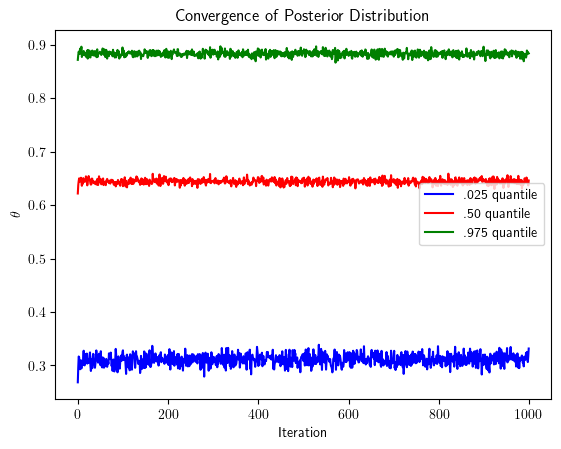

In [6]:
colors = np.array(['blue', 'red', 'green'])
labels = np.array(['.025 quantile', '.50 quantile', '.975 quantile'])

for iiQuantile in range(len(quantiles)):

    plt.plot(convergenceQuantiles[iiQuantile, :], color = colors[iiQuantile], label = labels[iiQuantile])

plt.xlabel('Iteration')
plt.rc('text', usetex = True)
plt.ylabel('$\\theta$')
plt.title('Convergence of Posterior Distribution')
plt.legend()
plt.show()

In [7]:
## Stanford heart transplant censored data study

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

stanfordHeartData = pd.read_csv('heart_transplant.csv')

# Regressing log survival time on age to get sample variance of errors

aliveIndices = stanfordHeartData.index[stanfordHeartData['survived'] == 'alive'].tolist()
deadIndices = stanfordHeartData.index[stanfordHeartData['survived'] == 'dead'].tolist()
deadSurvivalTimes = stanfordHeartData['survtime'][deadIndices]
logDeadSurvivalTimes = np.array(np.log(deadSurvivalTimes))
deadAge = np.array(stanfordHeartData['age'][deadIndices])

aliveCensoredEventTimes = stanfordHeartData['survtime'][aliveIndices]
logAliveCensoredEventTimes = np.array(np.log(aliveCensoredEventTimes))
aliveAge = np.array(stanfordHeartData['age'][aliveIndices])
numCensoredEventTimes = len(aliveCensoredEventTimes)
allAge = np.append(deadAge.reshape(-1, 1), aliveAge.reshape(-1, 1), 0)

model = LinearRegression()

# Reshape the arrays
deadAgeReshaped = deadAge.reshape(-1, 1)
logDeadSurvivalTimesReshaped = logDeadSurvivalTimes.reshape(-1, 1)

model.fit(deadAgeReshaped, logDeadSurvivalTimesReshaped)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
yHat = model.predict(deadAgeReshaped)
residuals = yHat - logDeadSurvivalTimesReshaped # Flatten the predicted values
nonAugmentedResidualVariance = np.var(residuals)

# Draw o^2* from the chi square distribution

numObservedData = len(deadSurvivalTimes)
numIterations = 100
numImputations = 1000
currentResidualVariance = (numObservedData - 1) * nonAugmentedResidualVariance / np.random.chisquare(numObservedData - 1, numImputations)
designMatrix = np.ones([numObservedData, 2])
designMatrix[:, 1] = deadAgeReshaped.flatten()
jointPosteriorApprox = np.zeros([numImputations, 3])
jointPosteriorApprox[:, 2] = currentResidualVariance.reshape(-1, 1).flatten()
numTotalDatapoints = len(stanfordHeartData['age'])

## Not very pythonic, need to change to do it without a for loop

for iiImputation in range(numImputations):

    varStar = currentResidualVariance[iiImputation]
    covarianceMatrix = np.linalg.inv(varStar * designMatrix.T @ designMatrix) 
    tempBetaStars = np.random.multivariate_normal([beta0, beta1], covarianceMatrix, 1).reshape(1, -1)
    jointPosteriorApprox[iiImputation, 0:2] = tempBetaStars


## Now start the actual algorithm

augmentedSurvivalTimes = np.zeros([numCensoredEventTimes, numImputations]) ## row = data point, column = imputation number
quantiles = np.array([.025,.50, .975])
convergenceQuantiles = np.zeros([len(quantiles), numIterations])

for iiIteration in range(numIterations):

    print(iiIteration)

    for jjImputation in range(numImputations):

        # Randomly select from the mixture of posterior distributions

        randomIndex = random.randint(0, numImputations - 1)
        thetaStar = jointPosteriorApprox[randomIndex, :]
        sigmaSqStar = thetaStar[-1]
        beta0Star = thetaStar[0]
        beta1Star = thetaStar[1]

        # Generate the augmented data by sampling errors and adding to right censored event time

        for kkCensoredEventTime in range(numCensoredEventTimes):

            predictedSurvivalTime = (beta0Star + beta1Star * aliveAge[kkCensoredEventTime])
            predictedError = predictedSurvivalTime - logAliveCensoredEventTimes[kkCensoredEventTime]
            drawFromConditionalErroDistribution = np.random.normal(0, sigmaSqStar)

            while drawFromConditionalErroDistribution < predictedError:

                drawFromConditionalErroDistribution = np.random.normal(0, sigmaSqStar)

            augmentedSurvivalTimes[kkCensoredEventTime, jjImputation] = predictedSurvivalTime + drawFromConditionalErroDistribution

        # Update the approximation to the posterior 
        # Randomly select the augmented data to use, then do linear regression, then sample the sigmaSqStar, then beta0 and beta1

    for jjImputation in range(numImputations):

        randomIndex = random.randint(0, numImputations - 1)
        tempAugmentedData = augmentedSurvivalTimes[:, randomIndex]
        tempAugmentedDesignMatrix = np.append(np.ones([numCensoredEventTimes, 1]), aliveAge.reshape(-1, 1), 1)
        tempTotalDesignMatrix = np.append(designMatrix, tempAugmentedDesignMatrix, 0)
        tempAugmentedSurvivalTimes = np.append(logDeadSurvivalTimes.reshape(-1, 1), tempAugmentedData.reshape(-1, 1), 0)

        model.fit(tempTotalDesignMatrix[:, -1].reshape(-1, 1), tempAugmentedSurvivalTimes)

        ## Need to sample the coefficients from the posteriors for beta0 beta1 sigmaStar from augmented linear model and add to array
        # The posterior for the betas is normal centered around the least squares estimates with covar matrix inv(sample o^2 * X_T @ X)
        
        beta0 = model.intercept_[0]
        beta1 = model.coef_[0][0]
        yHat = model.predict(tempTotalDesignMatrix[:, -1].reshape(-1, 1))
        residuals = yHat - tempAugmentedSurvivalTimes
        sampleResidualVariance = np.var(residuals)
        sigmaSquaredStar = (numTotalDatapoints - 1) * sampleResidualVariance / np.random.chisquare(numTotalDatapoints - 1, 1)

        tempCovarianceMatrix = np.linalg.inv(sigmaSquaredStar * tempTotalDesignMatrix.T @ tempTotalDesignMatrix) 
        betasStar = np.random.multivariate_normal([beta0, beta1], tempCovarianceMatrix, 1).reshape(1, -1)
        jointPosteriorApprox[iiImputation, -1] = sigmaSquaredStar
        jointPosteriorApprox[iiImputation, 0:2] = betasStar

    # This is for one random variable only, Beta1

    convergenceQuantiles[:, iiIteration] = np.quantile(jointPosteriorApprox[:, 1], quantiles, axis = 0)

## IT MIGHT HAVE SOMETHING TO DO WITH THE SCALES
            
## Each iteration gives you an approximation to the posterior distribution
## Impute the m = 500 values for augmented data, then with the augmented data, sample from the mixture
## of posterior distributions (randomly sample augmented data, use that to calculate and sample from that beta posterior)
# So the jointPosteriorApprox matris is exactly that, a sample from the last posterior distribution 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# Plot the joint distribution of beta0 and beta1 together

beta0Distribution = jointPosteriorApprox[:, 0]
beta1Distribution = jointPosteriorApprox[:, 1]
plt.scatter(beta1Distribution, beta0Distribution, color = 'black')
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')
plt.xlim(-.05, .05)
plt.ylim(2, 6)
plt.title('Augmented Posterior Joint Distribution Approximation for $\\beta_0$ and $\\beta_1$')
plt.show()

model.fit(deadAgeReshaped, logDeadSurvivalTimesReshaped)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
yHat = model.predict(deadAgeReshaped)
residuals = yHat - logDeadSurvivalTimesReshaped # Flatten the predicted values
nonAugmentedResidualVariance = np.var(residuals)
numSamples = 1000
nonAugmentedPosteriorApprox = np.zeros([numSamples, 3])


for iiSample in range(numSamples):

    nonAugmentedSampleResidualVariance = (numObservedData - 1) * nonAugmentedResidualVariance / np.random.chisquare(numObservedData - 1, 1)
    nonAugCovarMatrix = np.linalg.inv(nonAugmentedSampleResidualVariance * designMatrix.T @ designMatrix)
    betasStar = np.random.multivariate_normal([beta0, beta1], covarianceMatrix, 1).reshape(1, -1)
    nonAugmentedPosteriorApprox[iiSample, 0:2] = betasStar
    nonAugmentedPosteriorApprox[iiSample, -1] = nonAugmentedSampleResidualVariance

beta0Distribution = nonAugmentedPosteriorApprox[:, 0]
beta1Distribution = nonAugmentedPosteriorApprox[:, 1]
plt.scatter(beta1Distribution, beta0Distribution, color = 'black')
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')
plt.xlim(-.05, .05)
plt.ylim(2, 6)
plt.title('Nonaugmented Posterior Joint Distribution Approximation for $\\beta_0$ and $\\beta_1$')
plt.show()

# Plot the mean regression lines for augmented and nonaugmented posterior distributions

x = np.linspace(np.min(deadAge), np.max(deadAge), 1000)
meanAugmentedB0 = np.mean(jointPosteriorApprox[:, 0])
meanAugmentedB1 = np.mean(jointPosteriorApprox[:, 1])
plt.plot(x, meanAugmentedB0 + meanAugmentedB1 * x, color = 'r', label = 'Augmented')
plt.xlabel('Age')
plt.ylabel('Log Survival Time')
plt.title('Mean Regression Lines for Nonaugmented and Augmented Analysis')

meanNonaugmentedB0 = np.mean(nonAugmentedPosteriorApprox[:, 0])
meanNonaugmentedB1 = np.mean(nonAugmentedPosteriorApprox[:, 1])
plt.plot(x, meanNonaugmentedB0 + meanNonaugmentedB1 * x, color = 'blue', label = 'Nonaugmented')
plt.legend()
plt.show()

# Plot the exponential transformation

plt.plot(x, np.exp(meanAugmentedB0 + meanAugmentedB1 * x), color = 'r', label = 'Augmented')
plt.plot(x, np.exp(meanNonaugmentedB0 + meanNonaugmentedB1 * x), color = 'blue', label = 'Nonaugmented')
plt.xlabel('Age')
plt.ylabel('Survival Time')
plt.legend()
plt.title('Exponential Transformation for Nonaugmented and Augmented Regression Lines')
plt.show()




In [ ]:
augmentedBeta1Posterior = jointPosteriorApprox[:, 1]
augmentedBeta0Posterior = jointPosteriorApprox[:, 0]
augmentedSigmaSqPosterior = jointPosteriorApprox[:, -1]

# Sample the posterior for the nonaugmented data

plt.hist(augmentedBeta1Posterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedBeta1Posterior = nonAugmentedPosteriorApprox[:, 1]
plt.hist(nonAugmentedBeta1Posterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\beta_1$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Slope of Linear Regression Model')
plt.legend()
plt.show()

plt.hist(augmentedBeta0Posterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedBeta0Posterior = nonAugmentedPosteriorApprox[:, 0]
plt.hist(nonAugmentedBeta0Posterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\beta_0$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Intercept of Linear Regression Model')
plt.legend()
plt.show()

plt.hist(augmentedSigmaSqPosterior, bins = 30, density = True, color = 'skyblue', edgecolor = 'black', alpha = .5, label = 'augmented')
nonAugmentedSigmaSqPosterior = nonAugmentedPosteriorApprox[:, -1]
plt.hist(nonAugmentedSigmaSqPosterior, bins = 30, density = True, color = 'red', edgecolor = 'black', alpha = .5, label = 'nonaugmented')
plt.rc('text', usetex = True)
plt.xlabel('$\\sigma^2$')
plt.ylabel('Density')
plt.title('Comparing Posterior Distributions for Error Variance of Linear Regression Model')
plt.legend()
plt.show()

## overlay the posterior distribution without the augmented data with the posterior distribution with the augmented data

## plot the mean regression line for the augmented posterior (mean of b0 and b1) next to the mean regression line for the non augmented posterior
# which is just the least squares estimate that you got before the algorithm, compare the differences 

# Can look at more examples for data augmentation, or can look at the math behind convergence, or can DO CARD SHUFFLING ANALYSIS!